In [1]:
# 1

########## 12 March 2019 - Alec S. Hirschauer ##########
# Having presented my work at the Dusting the Universe 
# conference in Tucson, AZ from March 4th to March 9th,
# I have a solid procedure for identifying dusty stars.
#
# The thing I want to change with this notebook is that
# earlier, for CMDs 1 & 2, I failed to establish the
# TRGBs or subsequent bins and color-cut boundaries with
# data that had been trimmed of sources with high
# photometric errors (> 0.1 dex).
#
# When I noticed this the last time, I checked the TRGB
# values and found that the difference that it makes is
# basically negligible, and that the subsequent change
# in the bins and catalogs should also be negligible.
#
# But for the sake of consistency and completeness,
# I have decided to re-do everything for these two CMDs.
#
# The procedures will be the same as from the "20Feb2019"
# notebooks, from which I will be copying a lot of material.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the second file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the [3.6] vs J-[3.6] CMD & Hess diagram.

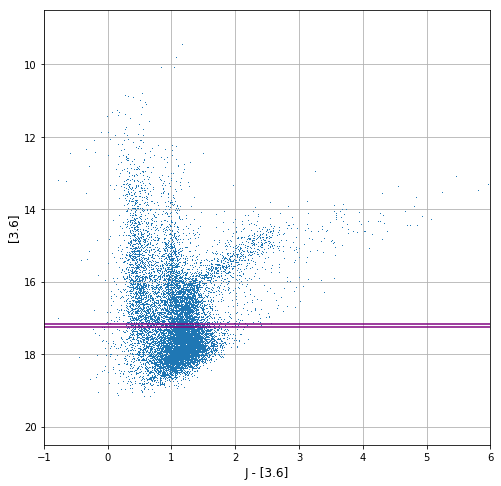

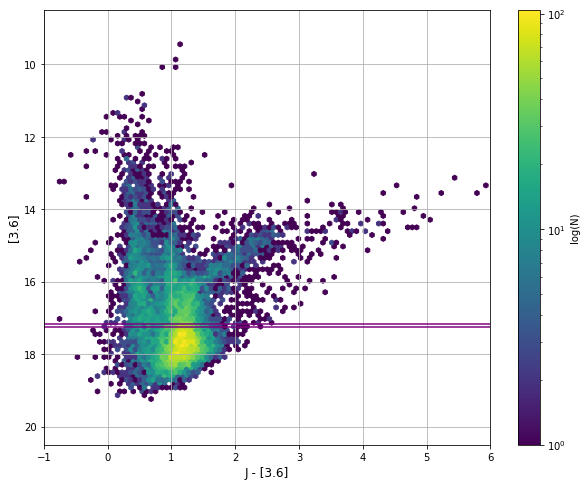

In [6]:
# 6

# [3.6] vs J-[3.6]
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',')
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
plt.axhline(y=17.243, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.159, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[3.6]_vs_J-[3.6]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
im1 = ax1.hexbin(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('J - [3.6]', size=12)
ax1.set_ylabel('[3.6]', size=12)
plt.axhline(y=17.243, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.159, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[3.6]_vs_J-[3.6]_hist.pdf')

In [7]:
# 7

# The second thing I'll do is determine where the TRGB should be.
#
# With the Sibbons+ data I had a reference point, but with the Khan+ data
# I'm starting from scratch.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

low_error_jMINUSthreesixDATA = jMINUSthreesixDATA[(jMINUSthreesixDATA.eJmag < 0.1) & (jMINUSthreesixDATA.e36mag < 0.1)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print(len(jMINUSthreesixDATA))
print(len(low_error_jMINUSthreesixDATA))

13743
8533


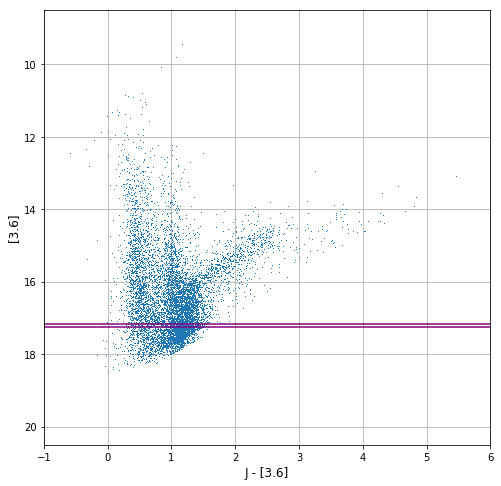

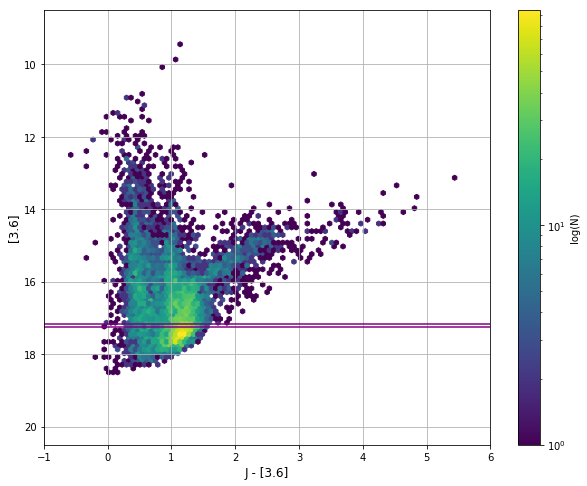

In [8]:
# 8

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# [3.6] vs J-[3.6] (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(low_error_jMINUSthreesixDATA.jMINUSthreesix, low_error_jMINUSthreesixDATA.k36mag, ',')
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
plt.axhline(y=17.243, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.159, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
#plt.savefig('[3.6]_vs_J-[3.6]_plot.pdf')
plt.grid(True)
plt.show()
plt.close()
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.0, 6.0)
plt.ylim(20.5, 8.5)
im1 = ax1.hexbin(low_error_jMINUSthreesixDATA.jMINUSthreesix, low_error_jMINUSthreesixDATA.k36mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('J - [3.6]', size=12)
ax1.set_ylabel('[3.6]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.axhline(y=17.243, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.159, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
#plt.savefig('[3.6]_vs_J-[3.6]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

In [9]:
# 9

# Definitely looks cleaner than before.
#
# I'll use this trimmed catalog to develop the color cuts themselves,
# but the full catalog when I'm doing the actual source identification.
#
##################################################

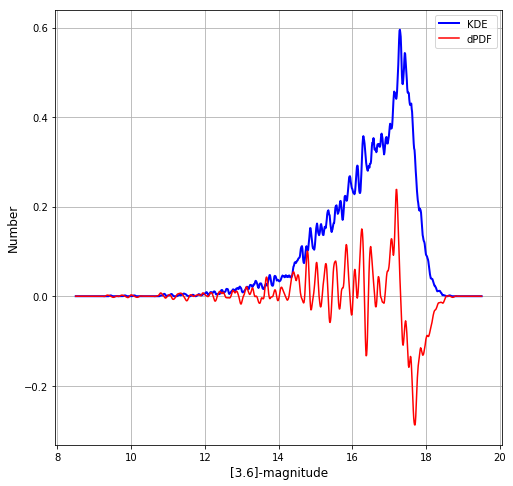

In [10]:
# 10

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'jMINUSthreesix.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('Jmag', 'f8'), ('eJmag', 'f8'), ('jMINUSthreesix', 'f8'), ('ejMINUSthreesix', 'f8')]) 
    m = table['k36mag']
    dm = table['e36mag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (8,8))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    plt.xlabel('[3.6]-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()
    #plt.savefig('CMD2_KDE.png')

def main():

    #Read from input table into variables m and dm
    # m, dm = getdata(infile = infile)
    #m = jMINUSthreesixHIST.k36mag
    #dm = jMINUSkHIST.e36mag
    m = low_error_jMINUSthreesixDATA.k36mag
    dm = low_error_jMINUSthreesixDATA.e36mag

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) #smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()


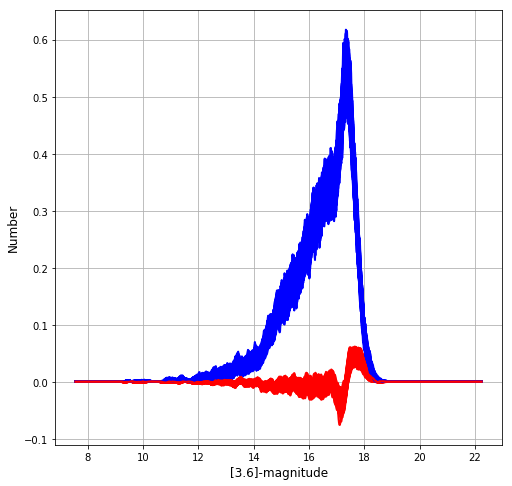

(17.1567168008008, 0.0798487307867418)

In [11]:
# 11

# This cell contains the MCKDE code routine to find the TRGB
# which we are intending on implementing for finding the breaks
# between different stellar types.
#
# Our problem so far has been twofold:
#
# (1) By realizing each time a thousand times, we are giving the
#     analysis a large number of opportunities to explore unlikely
#     paths, and so the resulting unertainties are extremely large.
#
#     Sundar has talked to Peter about this, realizing that what
#     we really should do is find the "natural width" of the
#     distributions, which is an estimate of the standard deviations,
#     which is the 68% spread.
#
# (2) The Savitzky-Golay filter (rather than Sobel filter) is used
#     to determine where the maxima in derivative to the Epanechnikov
#     curve fit to the data is located, which is fine for finding the
#     TRGB, but is less obviously usable for finding the local minima
#     of inflection points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('Jmag', 'f8'), ('eJmag', 'f8'), ('jMINUSthreesix', 'f8'), ('ejMINUSthreesix', 'f8')]) 
    m = table['k36mag']
    dm = table['e36mag']
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (8,8))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('[3.6]-magnitude', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
        #plt.savefig('CMD2_MCKDE.png')
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
    # m, dm = getdata(infile = infile)
    #m = jMINUSthreesixHIST.k36mag
    #dm = jMINUSkHIST.e36mag
    m = low_error_jMINUSthreesixDATA.k36mag
    dm = low_error_jMINUSthreesixDATA.e36mag

    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


In [12]:
# 12

# Now that I have the TRGB value and error for the low-error sources,
# I can make the magnitude-span boxes of n = 1,000 sources
# and their associated KDEs, for which I'll evaluate the local minima.

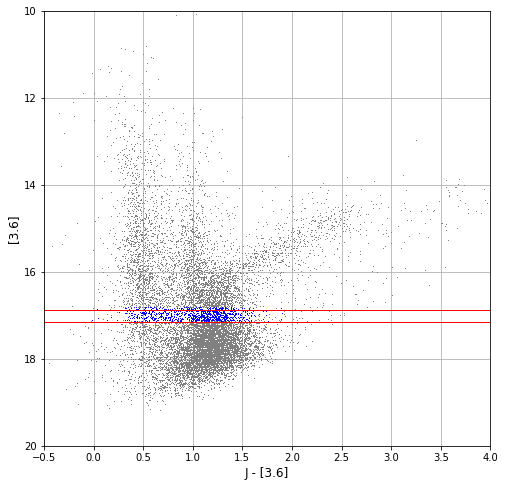

1006
0.09114285714285714
17.155
16.875


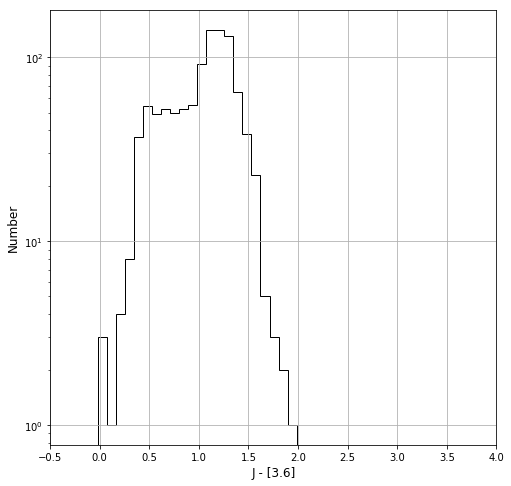

In [13]:
# 13 (Bin 1)

# Here I'm making the CMD of *ONLY* the sources within the first bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 17.155
initial_width = 0.500
width_change = 0.010

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*18.))]

bin_end = TRGB-initial_width*1.+width_change*22.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 1 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

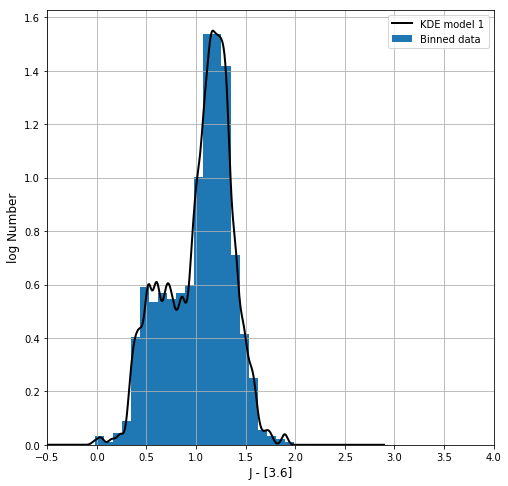

In [14]:
# 14 (Bin 1)

# [3.6] = 17.155 to 16.875
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.8006, 0.8008)
#plt.ylim(0.5052, 0.5053)
#plt.xlim(0.89, 0.9)
#plt.ylim(0.53, 0.54)
#plt.xlim(1.168, 1.170)
#plt.ylim(1.55, 1.551)
#plt.xlim(1.685, 1.690)
#plt.ylim(0.052, 0.053)
#plt.xlim(1.815, 1.825)
#plt.ylim(0.004, 0.006)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: [3.6] = 17.105
### boundary 1: J-K = 0.805 ? 0.801
### boundary 2: J-K = 1.055* -> 1.071*? -> 1.062*? 1.068 ? (0.895+1.169)/2 = 1.032
### boundary 3: J-K = 1.312 ? (1.169+1.687)/2 = 1.41195
### boundary 4: J-K = 1.826 ? 1.820

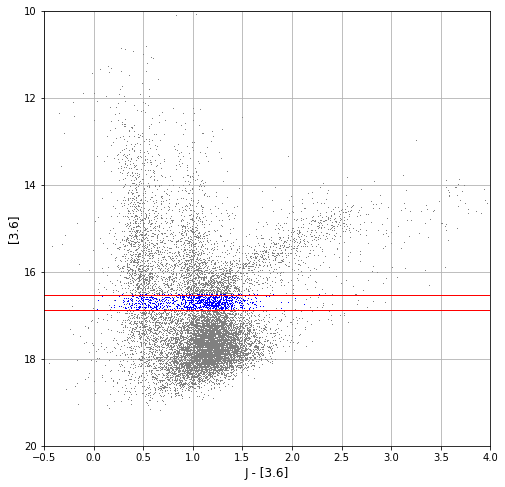

1014
0.08277777777777778
16.875
16.525


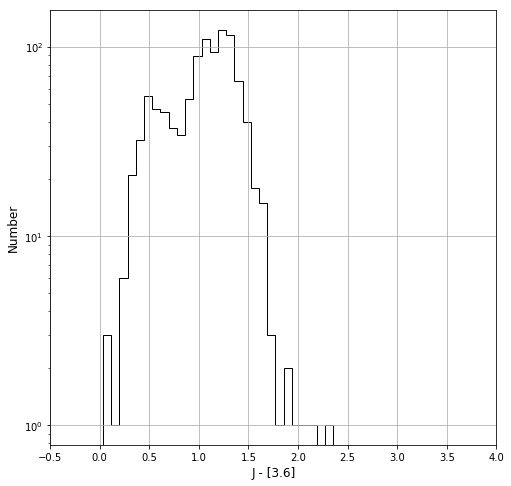

In [15]:
# 15 (Bin 2)

# Here I'm making the CMD of *ONLY* the sources within the second bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 16.875

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*15.))]

bin_end = TRGB-initial_width*1.+width_change*15.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 2 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

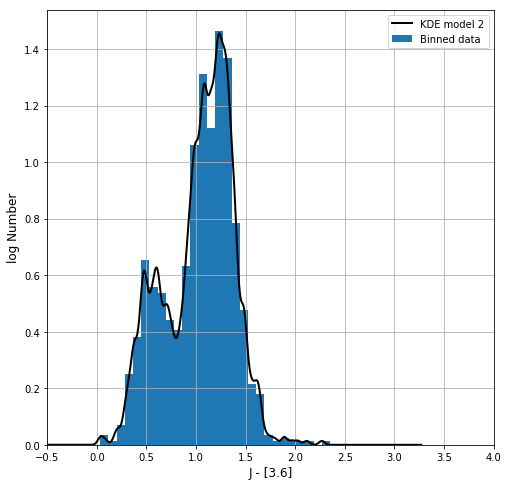

In [16]:
# 16 (Bin 2)

# [3.6] = 16.875 to 16.525
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 2')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.795, 0.805)
#plt.ylim(0.375, 0.38)
#plt.xlim(1.115, 1.125)
#plt.ylim(1.236, 1.238)
#plt.xlim(1.587, 1.591)
#plt.ylim(0.226, 0.227)
#plt.xlim(1.8425, 1.845)
#plt.ylim(0.014, 0.015)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: [3.6] = 16.700
### boundary 1: J-K = 0.785 -> 0.850 ? 0.799
### boundary 2: J-K = 1.030* -> 1.053* (1.048?) 1.059 ? 1.122
### boundary 3: J-K = 1.456 ? 1.589
### boundary 4: J-K = 1.808 -> 2.070?x ? 1.843

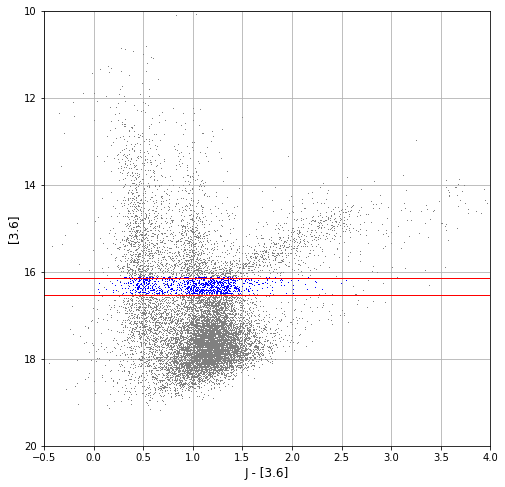

1005
0.09603846153846152
16.525
16.145


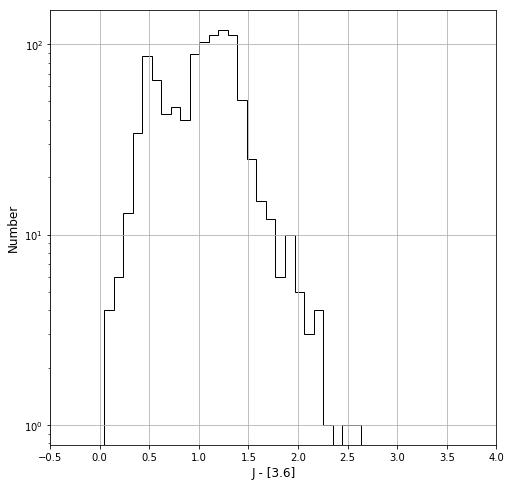

In [17]:
# 17 (Bin 3)

# Here I'm making the CMD of *ONLY* the sources within the third bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 16.525

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*10.))]

bin_end = TRGB-initial_width*1.+width_change*12.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 3 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

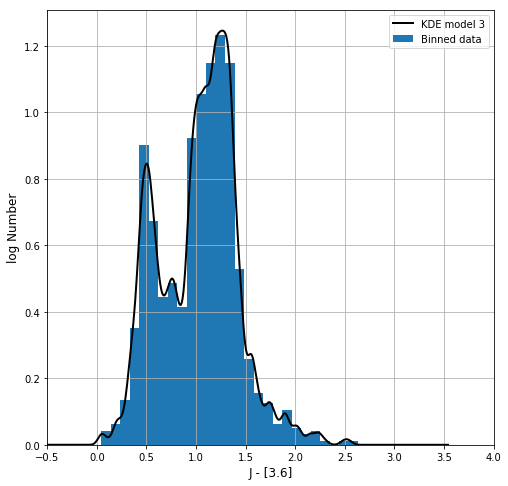

In [18]:
# 18 (Bin 3)

# [3.6] = 16.525 to 16.145
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 3')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.84, 0.85)
#plt.ylim(0.42, 0.422)
#plt.xlim(1.115, 1.12)
#plt.ylim(1.080, 1.082)
#plt.xlim(1.522, 1.523)
#plt.ylim(0.26985, 0.270)
#plt.xlim(1.835, 1.840)
#plt.ylim(0.075, 0.076)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 16.335
### boundary 1: J-K = 0.799 ? 0.846
### boundary 2: J-K = 1.138 ? 1.117
### boundary 3: J-K = 1.530 ? 1.522
### boundary 4: J-K = 1.850 ? 1.838

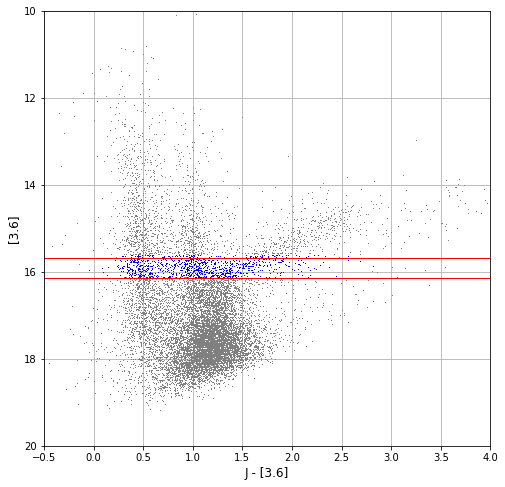

1019
0.12421739130434782
16.145
15.674999999999999


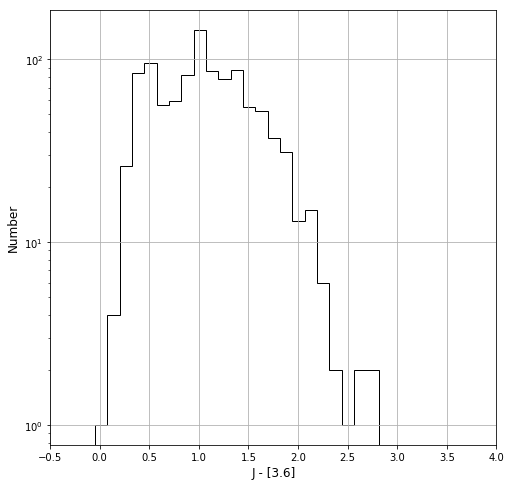

In [19]:
# 19 (Bin 4)

# Here I'm making the CMD of *ONLY* the sources within the fourth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 16.145

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.-width_change*2.))]

bin_end = TRGB-initial_width*1.+width_change*3.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 4 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

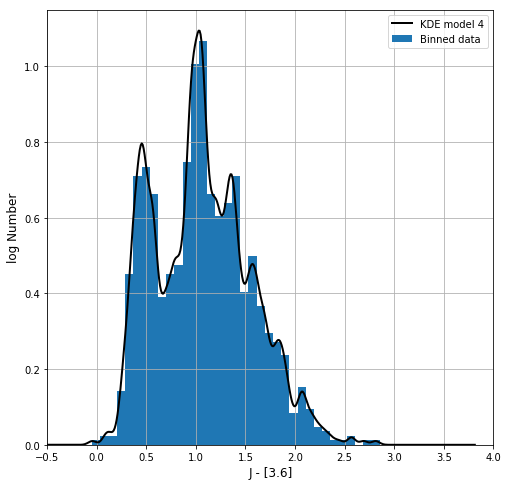

In [20]:
# 20 (Bin 4)

# [3.6] = 16.145 to 15.675
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/1.5, binwidth/1.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 4')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.66, 0.67)
#plt.ylim(0.395, 0.405)
#plt.xlim(1.255, 1.265)
#plt.ylim(0.605, 0.606)
#plt.xlim(1.494, 1.497)
#plt.ylim(0.425, 0.426)
#plt.xlim(1.990, 1.994)
#plt.ylim(0.1019, 0.102)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 15.910
### boundary 1: J-K = 0.843 ? 0.668
### boundary 2: J-K = 1.115 -> 1.262 => 1.1885 ? 1.262
### boundary 3: J-K = 1.505 ? 1.495
### boundary 4: J-K = 1.992 ? 1.992

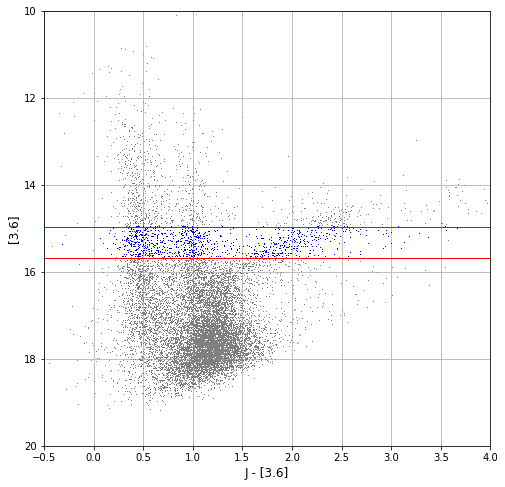

1000
0.2216111111111111
15.675
14.975000000000001


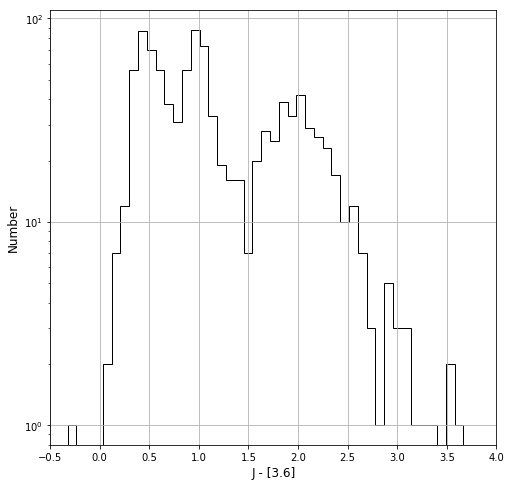

In [21]:
# 21 (Bin 5)

# Here I'm making the CMD of *ONLY* the sources within the fifth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 15.675

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.-width_change*22.))]

bin_end = TRGB-initial_width*1.-width_change*20.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 5 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth/2.5, binwidth/2.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

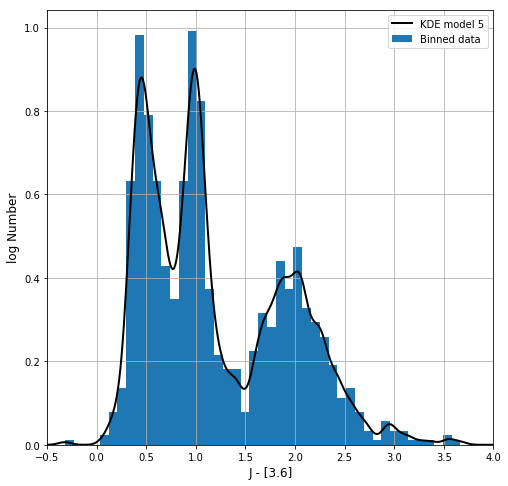

In [22]:
# 22 (Bin 5)

# [3.6] = 15.675 to 14.975
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/2.5, binwidth/2.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 5')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.765, 0.77)
#plt.ylim(0.42, 0.422)
#plt.xlim(1.2944, 1.2945)
#plt.ylim(0.1887, 0.18875)
#plt.xlim(1.485, 1.4875)
#plt.ylim(0.1339, 0.134)
#plt.xlim(2.818, 2.820)
#plt.ylim(0.0258, 0.026)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 15.325
### boundary 1: J-K = 0.763 ? 0.766
### boundary 2: J-K = 1.341 -> 1.2935 -> 1.282 ? 1.294
### boundary 3: J-K = 1.506 ? 1.486
### boundary 4: J-K = 2.825 ? 2.819

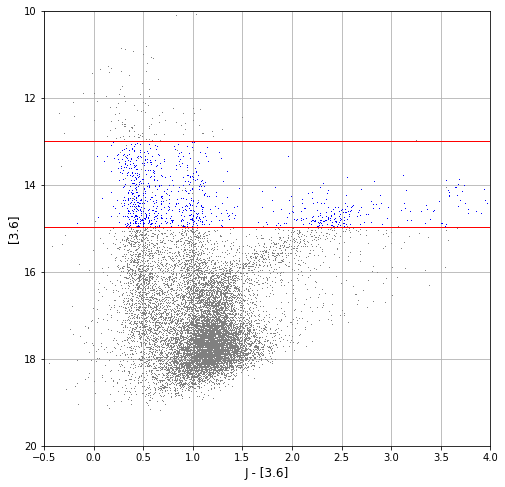

866
0.25636363636363635
14.975
13.0


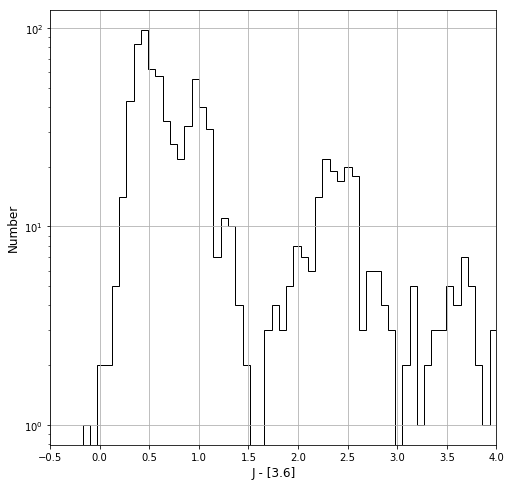

In [23]:
# 23 (Bin 6)

# Here I'm making the CMD of *ONLY* the sources within the sixth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 14.975

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > 13.)]

bin_end = 13.0

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 6 - lower boundary
plt.axhline(y=13.0, linewidth=1.0, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth/3.5, binwidth/3.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

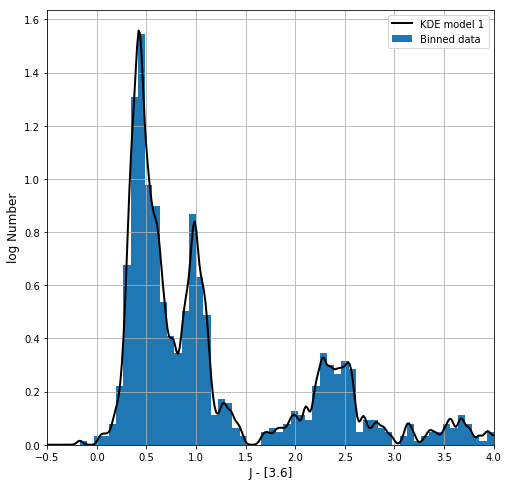

In [24]:
# 24 (Bin 6)

# [3.6] = 14.975 to 13.000
#
kde_data = jMINUSthreesixHIST.jMINUSthreesix.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/3.5, binwidth/3.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/8.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.818, 0.820)
#plt.ylim(0.341, 0.343)
#plt.xlim(1.216, 1.218)
#plt.ylim(0.116, 0.117)
#plt.xlim(2.64, 2.645)
#plt.ylim(0.085, 0.09)

plt.legend()
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 13.9875
### boundary 1: J-K = 0.789 ? 0.819
### boundary 2: J-K = 1.217 ? 1.217
### boundary 3: J-K = 3.024 -> 2.641 ? 2.641
### boundary 4: J-K = 

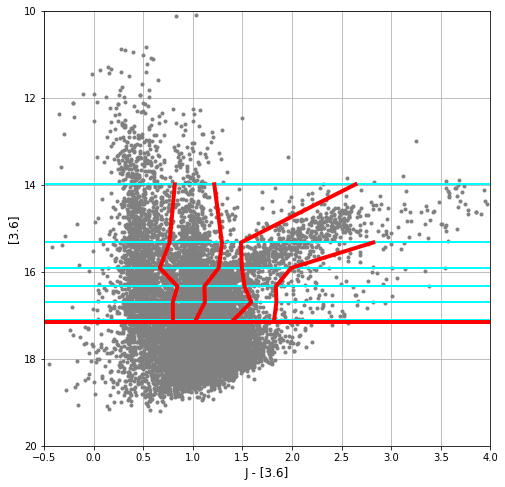

In [25]:
# 25

# [3.6] vs J-[3.6]
# CMD with color-points and lines
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
### where are the magnitude span bin midpoints?
#
plt.axhline(y=17.105, linewidth=2.0, color='cyan')
plt.axhline(y=16.700, linewidth=2.0, color='cyan')
plt.axhline(y=16.335, linewidth=2.0, color='cyan')
plt.axhline(y=15.910, linewidth=2.0, color='cyan')
plt.axhline(y=15.325, linewidth=2.0, color='cyan')
plt.axhline(y=13.9875, linewidth=2.0, color='cyan')
#
### where are the bin boundaries?
#
#plt.axhline(y=17.155, linewidth=2.0, color='red')
#plt.axhline(y=16.875, linewidth=2.0, color='red')
#plt.axhline(y=16.525, linewidth=2.0, color='red')
#plt.axhline(y=16.145, linewidth=2.0, color='red')
#plt.axhline(y=15.675, linewidth=2.0, color='red')
#plt.axhline(y=14.975, linewidth=2.0, color='red')
#plt.axhline(y=13.000, linewidth=2.0, color='red')
#
### plot points
#
yvalues1 = np.array([17.105, 16.700, 16.335, 15.910, 15.325, 13.9875])
yvalues2 = np.array([17.105, 16.700, 16.335, 15.910, 15.325, 13.9875])
yvalues3 = np.array([17.105, 16.700, 16.335, 15.910, 15.325, 13.9875])
yvalues4 = np.array([17.105, 16.700, 16.335, 15.910, 15.325])
boundary1 = np.array([0.801, 0.799, 0.846, 0.668, 0.766, 0.819])
boundary2 = np.array([1.032, 1.122, 1.117, 1.262, 1.294, 1.217])
boundary3 = np.array([1.41195, 1.589, 1.522, 1.495, 1.486, 2.641])
boundary4 = np.array([1.820, 1.843, 1.838, 1.992, 2.819])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
plt.plot(boundary4, yvalues4, linewidth=4.0, color='red')
#
plt.axhline(y=17.155, linewidth=4.0, color='red') # TRGB threshold
extremely_dusty = 2.637 # from previous analysis
#

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD2_bins.pdf')

-12.032798489853775 26.524075035394123
2.3876404494382073 14.315056179775285
-5.969387755102038 19.89755102040815
-25.235849056603637 34.65566037735837

-5.025487944890927 22.207634213547642
19.02205390955675 -8.849236466919203

-2.2874894097712453 20.334820672126508
11.268817204301019 -1.0949086021504577
-1.1580086580086522 17.04580086580085

-24.316628701595647 61.30192482915922
-0.9221853095138646 17.900536707652563


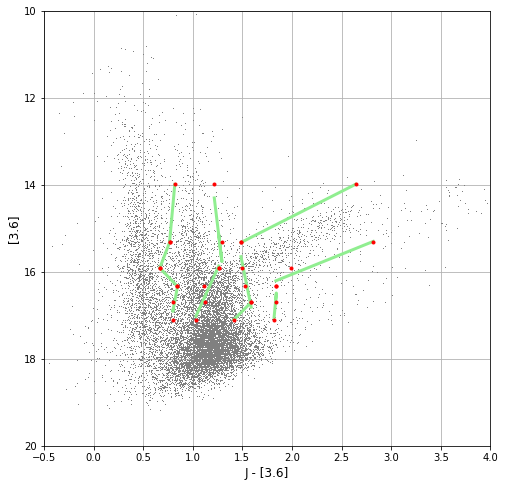

In [41]:
# 26

# Using the color-cut boundaries from the plot above,
# I can use the routine POLYFIT to fit functions,
# then use these functions to make logic statements
# to make the actual catalog cuts.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)

from numpy.polynomial.polynomial import polyfit

yvalues1a = np.array([17.105, 16.700, 16.335])
yvalues1b = np.array([16.335, 15.910])
yvalues1c = np.array([15.910, 15.325])
yvalues1d = np.array([15.325, 13.9875])

yvalues2a = np.array([17.105, 16.700, 16.335, 15.910])
yvalues2b = np.array([15.910, 15.325, 13.9875])

yvalues3a = np.array([17.105, 16.700])
yvalues3b = np.array([16.700, 16.335, 15.910, 15.325])
yvalues3c = np.array([15.325, 13.9875])

yvalues4a = np.array([17.105, 16.700, 16.335])
yvalues4b = np.array([16.335, 15.910, 15.325])

#

boundary1a = np.array([0.801, 0.799, 0.846])
boundary1b = np.array([0.846, 0.668])
boundary1c = np.array([0.668, 0.766])
boundary1d = np.array([0.766, 0.819])

boundary2a = np.array([1.032, 1.122, 1.117, 1.262])
boundary2b = np.array([1.262, 1.294, 1.217])

boundary3a = np.array([1.41195, 1.589])
boundary3b = np.array([1.589, 1.522, 1.495, 1.486])
boundary3c = np.array([1.486, 2.641])

boundary4a = np.array([1.820, 1.843, 1.838])
boundary4b = np.array([1.838, 1.992, 2.819])

#

b1a, m1a = polyfit(boundary1a, yvalues1a, 1)
b1b, m1b = polyfit(boundary1b, yvalues1b, 1)
b1c, m1c = polyfit(boundary1c, yvalues1c, 1)
b1d, m1d = polyfit(boundary1d, yvalues1d, 1)

b2a, m2a = polyfit(boundary2a, yvalues2a, 1)
b2b, m2b = polyfit(boundary2b, yvalues2b, 1)

b3a, m3a = polyfit(boundary3a, yvalues3a, 1)
b3b, m3b = polyfit(boundary3b, yvalues3b, 1)
b3c, m3c = polyfit(boundary3c, yvalues3c, 1)

b4a, m4a = polyfit(boundary4a, yvalues4a, 1)
b4b, m4b = polyfit(boundary4b, yvalues4b, 1)

#

print(m1a, b1a)
print(m1b, b1b)
print(m1c, b1c)
print(m1d, b1d)
print('')
print(m2a, b2a)
print(m2b, b2b)
print('')
print(m3a, b3a)
print(m3b, b3b)
print(m3c, b3c)
print('')
print(m4a, b4a)
print(m4b, b4b)

#

plt.plot(boundary1a, b1a + m1a * boundary1a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary1b, b1b + m1b * boundary1b, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary1c, b1c + m1c * boundary1c, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary1d, b1d + m1d * boundary1d, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary2a, b2a + m2a * boundary2a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary2b, b2b + m2b * boundary2b, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary3a, b3a + m3a * boundary3a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary3b, b3b + m3b * boundary3b, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary3c, b3c + m3c * boundary3c, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary4a, b4a + m4a * boundary4a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary4b, b4b + m4b * boundary4b, '-', linewidth=3.0, color='lightgreen')

#

plt.plot(boundary1a, yvalues1a, '.', color='red')
plt.plot(boundary1b, yvalues1b, '.', color='red')
plt.plot(boundary1c, yvalues1c, '.', color='red')
plt.plot(boundary1d, yvalues1d, '.', color='red')

plt.plot(boundary2a, yvalues2a, '.', color='red')
plt.plot(boundary2b, yvalues2b, '.', color='red')

plt.plot(boundary3a, yvalues3a, '.', color='red')
plt.plot(boundary3b, yvalues3b, '.', color='red')
plt.plot(boundary3c, yvalues3c, '.', color='red')

plt.plot(boundary4a, yvalues4a, '.', color='red')
plt.plot(boundary4b, yvalues4b, '.', color='red')

#

plt.grid(True)
plt.show()
plt.close()

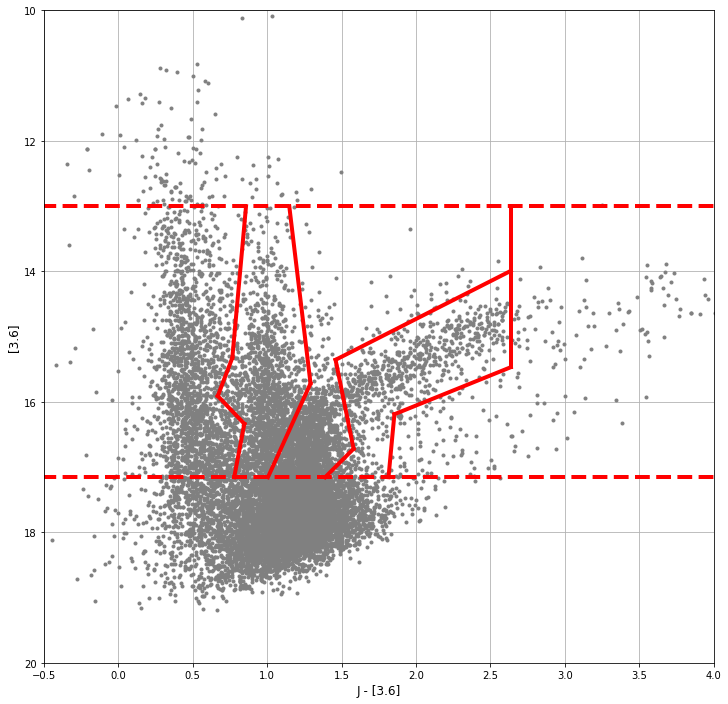

In [54]:
# 27

# With the lines defined by POLYFIT,
# I will now define final boundaries.

plt.figure(figsize=(12,12))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)

##########

# TRGB limit
#
x_TRGB = np.linspace(-1.0, 5.0, 100)
y_TRGB = 0.0*x_TRGB + 17.155

# brightness limit
#
x_bright = np.linspace(-1.0, 5.0, 100)
y_bright = 0.0*x_bright + 13.0

# dusty limit
#
extremely_dusty = 2.637 # from previous analysis

# Boundary 1
#
x_Boundary1a = np.linspace(0.778628, 0.84664682587104931, 100)
y_Boundary1a = -12.032798489853775*x_Boundary1a + 26.524075035394123

x_Boundary1b = np.linspace(0.84664682587104931, 0.6679999999999977, 100)
y_Boundary1b = 2.3876404494382073*x_Boundary1b + 14.315056179775285

x_Boundary1c = np.linspace(0.6679999999999977, 0.7659999999999997, 100)
y_Boundary1c = -5.969387755102038*x_Boundary1c + 19.89755102040815

x_Boundary1d = np.linspace(0.7659999999999997, 0.858131, 100)
y_Boundary1d = -25.235849056603637*x_Boundary1d + 34.65566037735837

# Boundary 2
#
x_Boundary2a = np.linspace(1.0054, 1.291477975938017, 100)
y_Boundary2a = -5.025487944890927*x_Boundary2a + 22.207634213547642

x_Boundary2b = np.linspace(1.291477975938017, 1.14863, 100)
y_Boundary2b = 19.02205390955675*x_Boundary2b + -8.849236466919203

# Boundary 3
#
x_Boundary3a = np.linspace(1.39009, 1.5807940823669194, 100)
y_Boundary3a = -2.2874894097712453*x_Boundary3a + 20.334820672126508

x_Boundary3b = np.linspace(1.5807940823669194, 1.459802339628154, 100)
y_Boundary3b = 11.268817204301019*x_Boundary3b + -1.0949086021504577

x_Boundary3c = np.linspace(1.459802339628154, 2.637, 100)
y_Boundary3c = -1.1580086580086522*x_Boundary3c + 17.04580086580085

# Boundary 4
#
x_Boundary4a = np.linspace(1.8155, 1.855200715576612, 100)
y_Boundary4a = -24.316628701595647*x_Boundary4a + 61.30192482915922

x_Boundary4b = np.linspace(1.855200715576612, 2.637, 100)
y_Boundary4b = -0.9221853095138646*x_Boundary4b + 17.900536707652563

# plot lines
#
plt.plot(x_TRGB, y_TRGB, '--', linewidth=4.0, color='red')
plt.plot(x_bright, y_bright, '--', linewidth=4.0, color='red')

plt.plot(x_Boundary1a, y_Boundary1a, linewidth=4.0, color='red')
plt.plot(x_Boundary1b, y_Boundary1b, linewidth=4.0, color='red')
plt.plot(x_Boundary1c, y_Boundary1c, linewidth=4.0, color='red')
plt.plot(x_Boundary1d, y_Boundary1d, linewidth=4.0, color='red')

plt.plot(x_Boundary2a, y_Boundary2a, linewidth=4.0, color='red')
plt.plot(x_Boundary2b, y_Boundary2b, linewidth=4.0, color='red')

plt.plot(x_Boundary3a, y_Boundary3a, linewidth=4.0, color='red')
plt.plot(x_Boundary3b, y_Boundary3b, linewidth=4.0, color='red')
plt.plot(x_Boundary3c, y_Boundary3c, linewidth=4.0, color='red')

plt.plot(x_Boundary4a, y_Boundary4a, linewidth=4.0, color='red')
plt.plot(x_Boundary4b, y_Boundary4b, linewidth=4.0, color='red')

y_extremely_dusty = np.linspace(15.4687, 13.0, 100)
x_extremely_dusty = 0.0*y_extremely_dusty + extremely_dusty
plt.plot(x_extremely_dusty, y_extremely_dusty, linewidth=4.0, color='red')


#plt.axhline(y=17.155, linewidth=2.0, color='cyan')
#plt.axhline(y=16.336544387613469, linewidth=2.0, color='cyan')
#plt.axhline(y=15.935196019812750, linewidth=2.0, color='cyan')
#plt.axhline(y=15.71732721437900, linewidth=2.0, color='cyan')
#plt.axhline(y=13.0, linewidth=2.0, color='cyan')

#plt.axhline(y=17.155, linewidth=2.0, color='magenta')
#plt.axhline(y=16.718770949683126, linewidth=2.0, color='magenta')
#plt.axhline(y=15.71732721437900, linewidth=2.0, color='magenta')
#plt.axhline(y=15.35533711753016, linewidth=2.0, color='magenta')
#plt.axhline(y=13.9921, linewidth=2.0, color='magenta')
#plt.axhline(y=13.0, linewidth=2.0, color='magenta')

#plt.axhline(y=16.718770949683126, linewidth=2.0, color='green')
#plt.axhline(y=16.1896978615482, linewidth=2.0, color='green')
#plt.axhline(y=15.4687, linewidth=2.0, color='green')
#plt.axhline(y=15.35533711753016, linewidth=2.0, color='green')


plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD2_boundaries.png')

1896
1571
1545
713
230


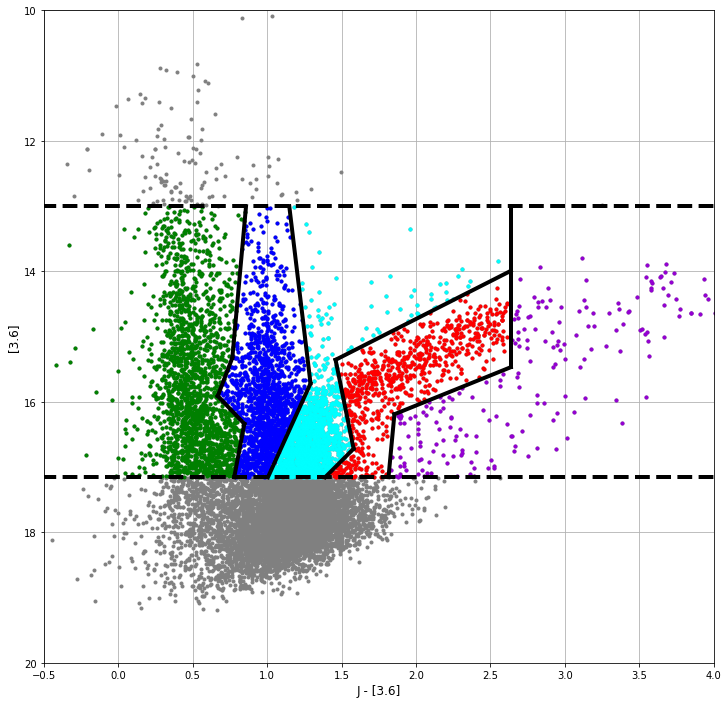

In [57]:
# 28

# Now that I have my boundaies, my next task is to chop up the
# master catalog to get the different population lists.

#
CMD2_region1 = pd.read_csv('CMD2_region1.csv')
CMD2_region2 = pd.read_csv('CMD2_region2.csv')
CMD2_region3 = pd.read_csv('CMD2_region3.csv')
CMD2_region4 = pd.read_csv('CMD2_region4.csv')
CMD2_region5 = pd.read_csv('CMD2_region5.csv')
#
print(len(CMD2_region1))
print(len(CMD2_region2))
print(len(CMD2_region3))
print(len(CMD2_region4))
print(len(CMD2_region5))

# CMD_2 ([3.6] vs J-[3.6])

plt.figure(figsize=(12,12))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)

plt.plot(CMD2_region1.jMINUSthreesix, CMD2_region1.k36mag, '.', color='green')
plt.plot(CMD2_region2.jMINUSthreesix, CMD2_region2.k36mag, '.', color='blue')
plt.plot(CMD2_region3.jMINUSthreesix, CMD2_region3.k36mag, '.', color='cyan')
plt.plot(CMD2_region4.jMINUSthreesix, CMD2_region4.k36mag, '.', color='red')
plt.plot(CMD2_region5.jMINUSthreesix, CMD2_region5.k36mag, '.', color='darkviolet')

##########

# TRGB limit
#
x_TRGB = np.linspace(-1.0, 5.0, 100)
y_TRGB = 0.0*x_TRGB + 17.155

# brightness limit
#
x_bright = np.linspace(-1.0, 5.0, 100)
y_bright = 0.0*x_bright + 13.0

# dusty limit
#
extremely_dusty = 2.637 # from previous analysis

# Boundary 1
#
x_Boundary1a = np.linspace(0.778628, 0.84664682587104931, 100)
y_Boundary1a = -12.032798489853775*x_Boundary1a + 26.524075035394123

x_Boundary1b = np.linspace(0.84664682587104931, 0.6679999999999977, 100)
y_Boundary1b = 2.3876404494382073*x_Boundary1b + 14.315056179775285

x_Boundary1c = np.linspace(0.6679999999999977, 0.7659999999999997, 100)
y_Boundary1c = -5.969387755102038*x_Boundary1c + 19.89755102040815

x_Boundary1d = np.linspace(0.7659999999999997, 0.858131, 100)
y_Boundary1d = -25.235849056603637*x_Boundary1d + 34.65566037735837

# Boundary 2
#
x_Boundary2a = np.linspace(1.0054, 1.291477975938017, 100)
y_Boundary2a = -5.025487944890927*x_Boundary2a + 22.207634213547642

x_Boundary2b = np.linspace(1.291477975938017, 1.14863, 100)
y_Boundary2b = 19.02205390955675*x_Boundary2b + -8.849236466919203

# Boundary 3
#
x_Boundary3a = np.linspace(1.39009, 1.5807940823669194, 100)
y_Boundary3a = -2.2874894097712453*x_Boundary3a + 20.334820672126508

x_Boundary3b = np.linspace(1.5807940823669194, 1.459802339628154, 100)
y_Boundary3b = 11.268817204301019*x_Boundary3b + -1.0949086021504577

x_Boundary3c = np.linspace(1.459802339628154, 2.637, 100)
y_Boundary3c = -1.1580086580086522*x_Boundary3c + 17.04580086580085

# Boundary 4
#
x_Boundary4a = np.linspace(1.8155, 1.855200715576612, 100)
y_Boundary4a = -24.316628701595647*x_Boundary4a + 61.30192482915922

x_Boundary4b = np.linspace(1.855200715576612, 2.637, 100)
y_Boundary4b = -0.9221853095138646*x_Boundary4b + 17.900536707652563

# plot lines
#
plt.plot(x_TRGB, y_TRGB, '--', linewidth=4.0, color='black')
plt.plot(x_bright, y_bright, '--', linewidth=4.0, color='black')

plt.plot(x_Boundary1a, y_Boundary1a, linewidth=4.0, color='black')
plt.plot(x_Boundary1b, y_Boundary1b, linewidth=4.0, color='black')
plt.plot(x_Boundary1c, y_Boundary1c, linewidth=4.0, color='black')
plt.plot(x_Boundary1d, y_Boundary1d, linewidth=4.0, color='black')

plt.plot(x_Boundary2a, y_Boundary2a, linewidth=4.0, color='black')
plt.plot(x_Boundary2b, y_Boundary2b, linewidth=4.0, color='black')

plt.plot(x_Boundary3a, y_Boundary3a, linewidth=4.0, color='black')
plt.plot(x_Boundary3b, y_Boundary3b, linewidth=4.0, color='black')
plt.plot(x_Boundary3c, y_Boundary3c, linewidth=4.0, color='black')

plt.plot(x_Boundary4a, y_Boundary4a, linewidth=4.0, color='black')
plt.plot(x_Boundary4b, y_Boundary4b, linewidth=4.0, color='black')

y_extremely_dusty = np.linspace(15.4687, 13.0, 100)
x_extremely_dusty = 0.0*y_extremely_dusty + extremely_dusty
plt.plot(x_extremely_dusty, y_extremely_dusty, linewidth=4.0, color='black')

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD2_populations.png')